In [1]:
""" Imports """
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib qt

In [2]:
""" Functions """

""" Quick function to wrangle a date object into the format we need to index from our dataframe"""
def format_date(date):
    day = date.day
    month = date.month
    year = date.year-2000
    return '/'.join([str(x) for x in [month, day, year]])

## Setup

In [10]:
""" Load the data """
data = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
# data = pd.read_csv('pop-facts/covid_confirmed_usafacts.csv')
usa_map = gpd.read_file('misc/cb_2019_us_county_20m.shp')
county_populations = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
# county_data = pd.read_csv('misc/2019_Gaz_counties_national.txt', sep='\t')

""" Add in county population data """
data['population'] = county_populations.pop('population')
    
print(data.shape)
print(usa_map.shape)
    
""" Couple of data wrangling steps """
data.dropna(inplace=True)
usa_map.dropna(inplace=True)
usa_map = usa_map.astype({'GEOID':'int64'})


(3195, 146)
(3220, 10)


In [12]:
""" Make new dataframe with daily new cases as % of the county population"""
daily_new_cases = data[['countyFIPS','County Name','State','stateFIPS','population']].copy()

""" Loop to get the daily new cases by county"""
day1 = datetime.date(month=1, day=22, year=2020)
one_day = timedelta(days=1) # timedelta object representing 1-day increments
today = day1
tomorrow = today + one_day

for ii in range((datetime.date.today()-day1).days-1):
    # Subtract cumulative cases at d-1 from d
    new_cases_today = data[format_date(tomorrow)].subtract(data[format_date(today)])
    
    # Convert it to percentage of county population
    new_cases_today_pct = (new_cases_today*100)/data['population'] # need to prevent log(zero) if we want to log transform
    
    # Bottom out at 0 and add 0.00001 for log compatibility, because some days have a decrease in confirmed cases?
    new_cases_today_pct = new_cases_today_pct.apply(lambda x: max(x, 0) + 0.00001)
    
    # If we wanna use log
    try:
        new_cases_today_log = np.log(new_cases_today_pct)
    except:
        print(new_cases_today_pct)
    
    # Increment both by one
    today = tomorrow
    tomorrow = today + one_day
    daily_new_cases[format_date(today)] = new_cases_today_pct
    daily_new_cases[format_date(today)] = new_cases_today_log

In [13]:
""" Merge the datasets using outer join """
# print(usa_map.shape)
# print(daily_new_cases.shape)
combined = usa_map.merge(daily_new_cases, how='outer', left_on='GEOID', right_on='countyFIPS')
combined = combined.dropna()
# Scale the map y values to look nicer on plot
combined.geometry = combined.geometry.scale(xfact=1., yfact=1.5, zfact=1.0, origin=(0, 0))
print(combined.shape)

(3142, 155)


In [19]:
flattened = np.array(combined.iloc[:, 15:]).flatten()
flattened.sort()
print(flattened)
# Visualize the probabilities
plt.hist(flattened, bins=200)
plt.ylim([0, 3000])
plt.title('Histogram of log-transformed daily infection rates by county (as percentage of county population)')
plt.show()

[-11.51292546 -11.51292546 -11.51292546 ...   1.05477611   1.44295615
   2.07308623]


In [26]:
a = [0.0001, 0.001, 0.01, 0.1]
print(np.log(a))

[-9.21034037 -6.90775528 -4.60517019 -2.30258509]


## Plots

In [37]:
""" Interactive US Map using sliderbar """

# Set up the figure
# Use these values for raw %
vmin = 0 # The % of population infected that corresponds to minimum (obviously, 0)
vmax = 0.025 # The % of population infected that corresponds to maximum on colorbar (
             # As of 6/10/2020, about 2% of data points go above this value)
    
    
# Use these values for log-transformed percentages
vmin = -11 # The % of population infected that corresponds to minimum (obviously, 0)
vmax = 0 # The % of population infected that corresponds to maximum on colorbar (
             # As of 6/10/2020, about 2% of data points go above this value)
cmap = 'CMRmap'
cmap = 'inferno'
    
fig, ax = plt.subplots(1,1, figsize=(16,9))
# Format the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.5)
# Plot
combined.plot(column=format_date(day1+timedelta(1)), 
              legend=True, ax=ax, cax=cax, 
              cmap=cmap, vmin=vmin, vmax=vmax)
ax.set_xlim([-130, -65])
ax.set_ylim([35, 75])
ax.set_title(format_date(day1+timedelta(1)))

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
# plt.tick_params(axis='both', which="both", bottom=False, top=False)



""" Set up the slider """
days_since_first_day = (datetime.date.today()-day1).days

axslider = plt.gcf()
axslider = plt.axes([0.20, 0.05, 0.60, 0.03], facecolor='#ffffff')
slider = Slider(axslider, 'Days', valmin=1, valmax=days_since_first_day, 
               valinit=1, valfmt='%i', valstep=1,
               # Rectangle properties
               facecolor='white', edgecolor='black')

def update_map(n_days):
    new_date = day1 + timedelta(n_days)
    combined.plot(column=format_date(new_date), 
                  legend=True, ax=ax, cax=cax, 
                  cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(new_date)

slider.on_changed(update_map)

fig.suptitle('Daily new COVID cases as log of percentage of county population (based on 2019 census)')
plt.show()

In [38]:
""" Save individual images to be animated """

# Set up the figure
# Use these values for raw %
vmin = 0 # The % of population infected that corresponds to minimum (obviously, 0)
vmax = 0.025 # The % of population infected that corresponds to maximum on colorbar (
             # As of 6/10/2020, about 2% of data points go above this value)
    
    
# Use these values for log-transformed percentages
vmin = -11 # The % of population infected that corresponds to minimum (obviously, 0)
vmax = 0 # The % of population infected that corresponds to maximum on colorbar (
             # As of 6/10/2020, about 2% of data points go above this value)

days_since_first_day = (datetime.date.today()-day1).days

""" Loop to save images"""
for n_days in np.arange(1, days_since_first_day):
    # Set up the new figure
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    # Format the colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.5)
    # Plot
    ax.set_xlim([-130, -65])
    ax.set_ylim([35, 75])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    new_date = day1 + timedelta(int(n_days))
    ax.set_title(new_date)
    
    combined.plot(column=format_date(new_date), 
                  legend=True, ax=ax, cax=cax,
                  cmap=cmap, vmin=vmin, vmax=vmax)
    
    fig.suptitle('Daily new COVID cases as log of percentage of county population (based on 2019 census)')
    plt.savefig(fname='images/'+new_date.strftime('%m-%d-%Y'))
    plt.close()

## Archived

In [11]:
""" Make new dataframe with daily new cases as % of the county population"""
daily_new_cases_df = data[['countyFIPS','County Name','State','stateFIPS','population']].copy()

""" Loop to get the daily new cases by county"""
day1 = datetime.date(month=1, day=22, year=2020)
one_day = timedelta(days=1) # timedelta object representing 1-day increments
today = day1
tomorrow = today + one_day

for ii in range((datetime.date.today()-day1).days-1):
    # Subtract cumulative cases at d-1 from d
    new_cases_today = data[format_date(tomorrow)].subtract(data[format_date(today)])
    
    # Convert it to percentage of county population
    new_cases_today_pct = new_cases_today/data['population']*100
    
    # Increment both by one
    today = tomorrow
    tomorrow = today + one_day
    daily_new_cases_df[format_date(today)] = new_cases_today_pct
print(daily_new_cases_df)

      countyFIPS            County Name State  stateFIPS  population  1/23/20  \
0              0  Statewide Unallocated    AL          1           0      NaN   
1           1001         Autauga County    AL          1       55869      0.0   
2           1003         Baldwin County    AL          1      223234      0.0   
3           1005         Barbour County    AL          1       24686      0.0   
4           1007            Bibb County    AL          1       22394      0.0   
...          ...                    ...   ...        ...         ...      ...   
3190       56037      Sweetwater County    WY         56       42343      0.0   
3191       56039           Teton County    WY         56       23464      0.0   
3192       56041           Uinta County    WY         56       20226      0.0   
3193       56043        Washakie County    WY         56        7805      0.0   
3194       56045          Weston County    WY         56        6927      0.0   

      1/24/20  1/25/20  1/2

<class 'pandas.core.frame.DataFrame'>


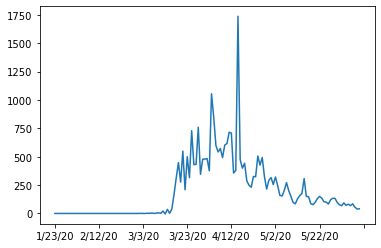

In [92]:
ny_cases = daily_new_cases_df.loc[daily_new_cases_df['County Name']=='New York County']
print(type(ny_cases))
ny_cases.iloc[0, 4:].plot()

In [ ]:
""" Load the data """
data = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv')
usa_map = gpd.read_file('misc/cb_2018_us_county_500k.shp')
county_populations = pd.read_csv('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
# county_data = pd.read_csv('misc/2019_Gaz_counties_national.txt', sep='\t')

""" Add in county population data """
data['population'] = county_populations.pop('population')

""" Drop a row in daily_new_cases_df if there isn't corresponding geolocation for that county in county_data """
for county_name in data['County Name'].unique():
    if county_name not in county_data['NAME'].unique():
#         print(county_name)
        data.drop(data[data['County Name']==county_name].index, inplace=True)
    
""" Drop NaNs just in case (there shouldn't be any) """
data.dropna(inplace=True)